In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

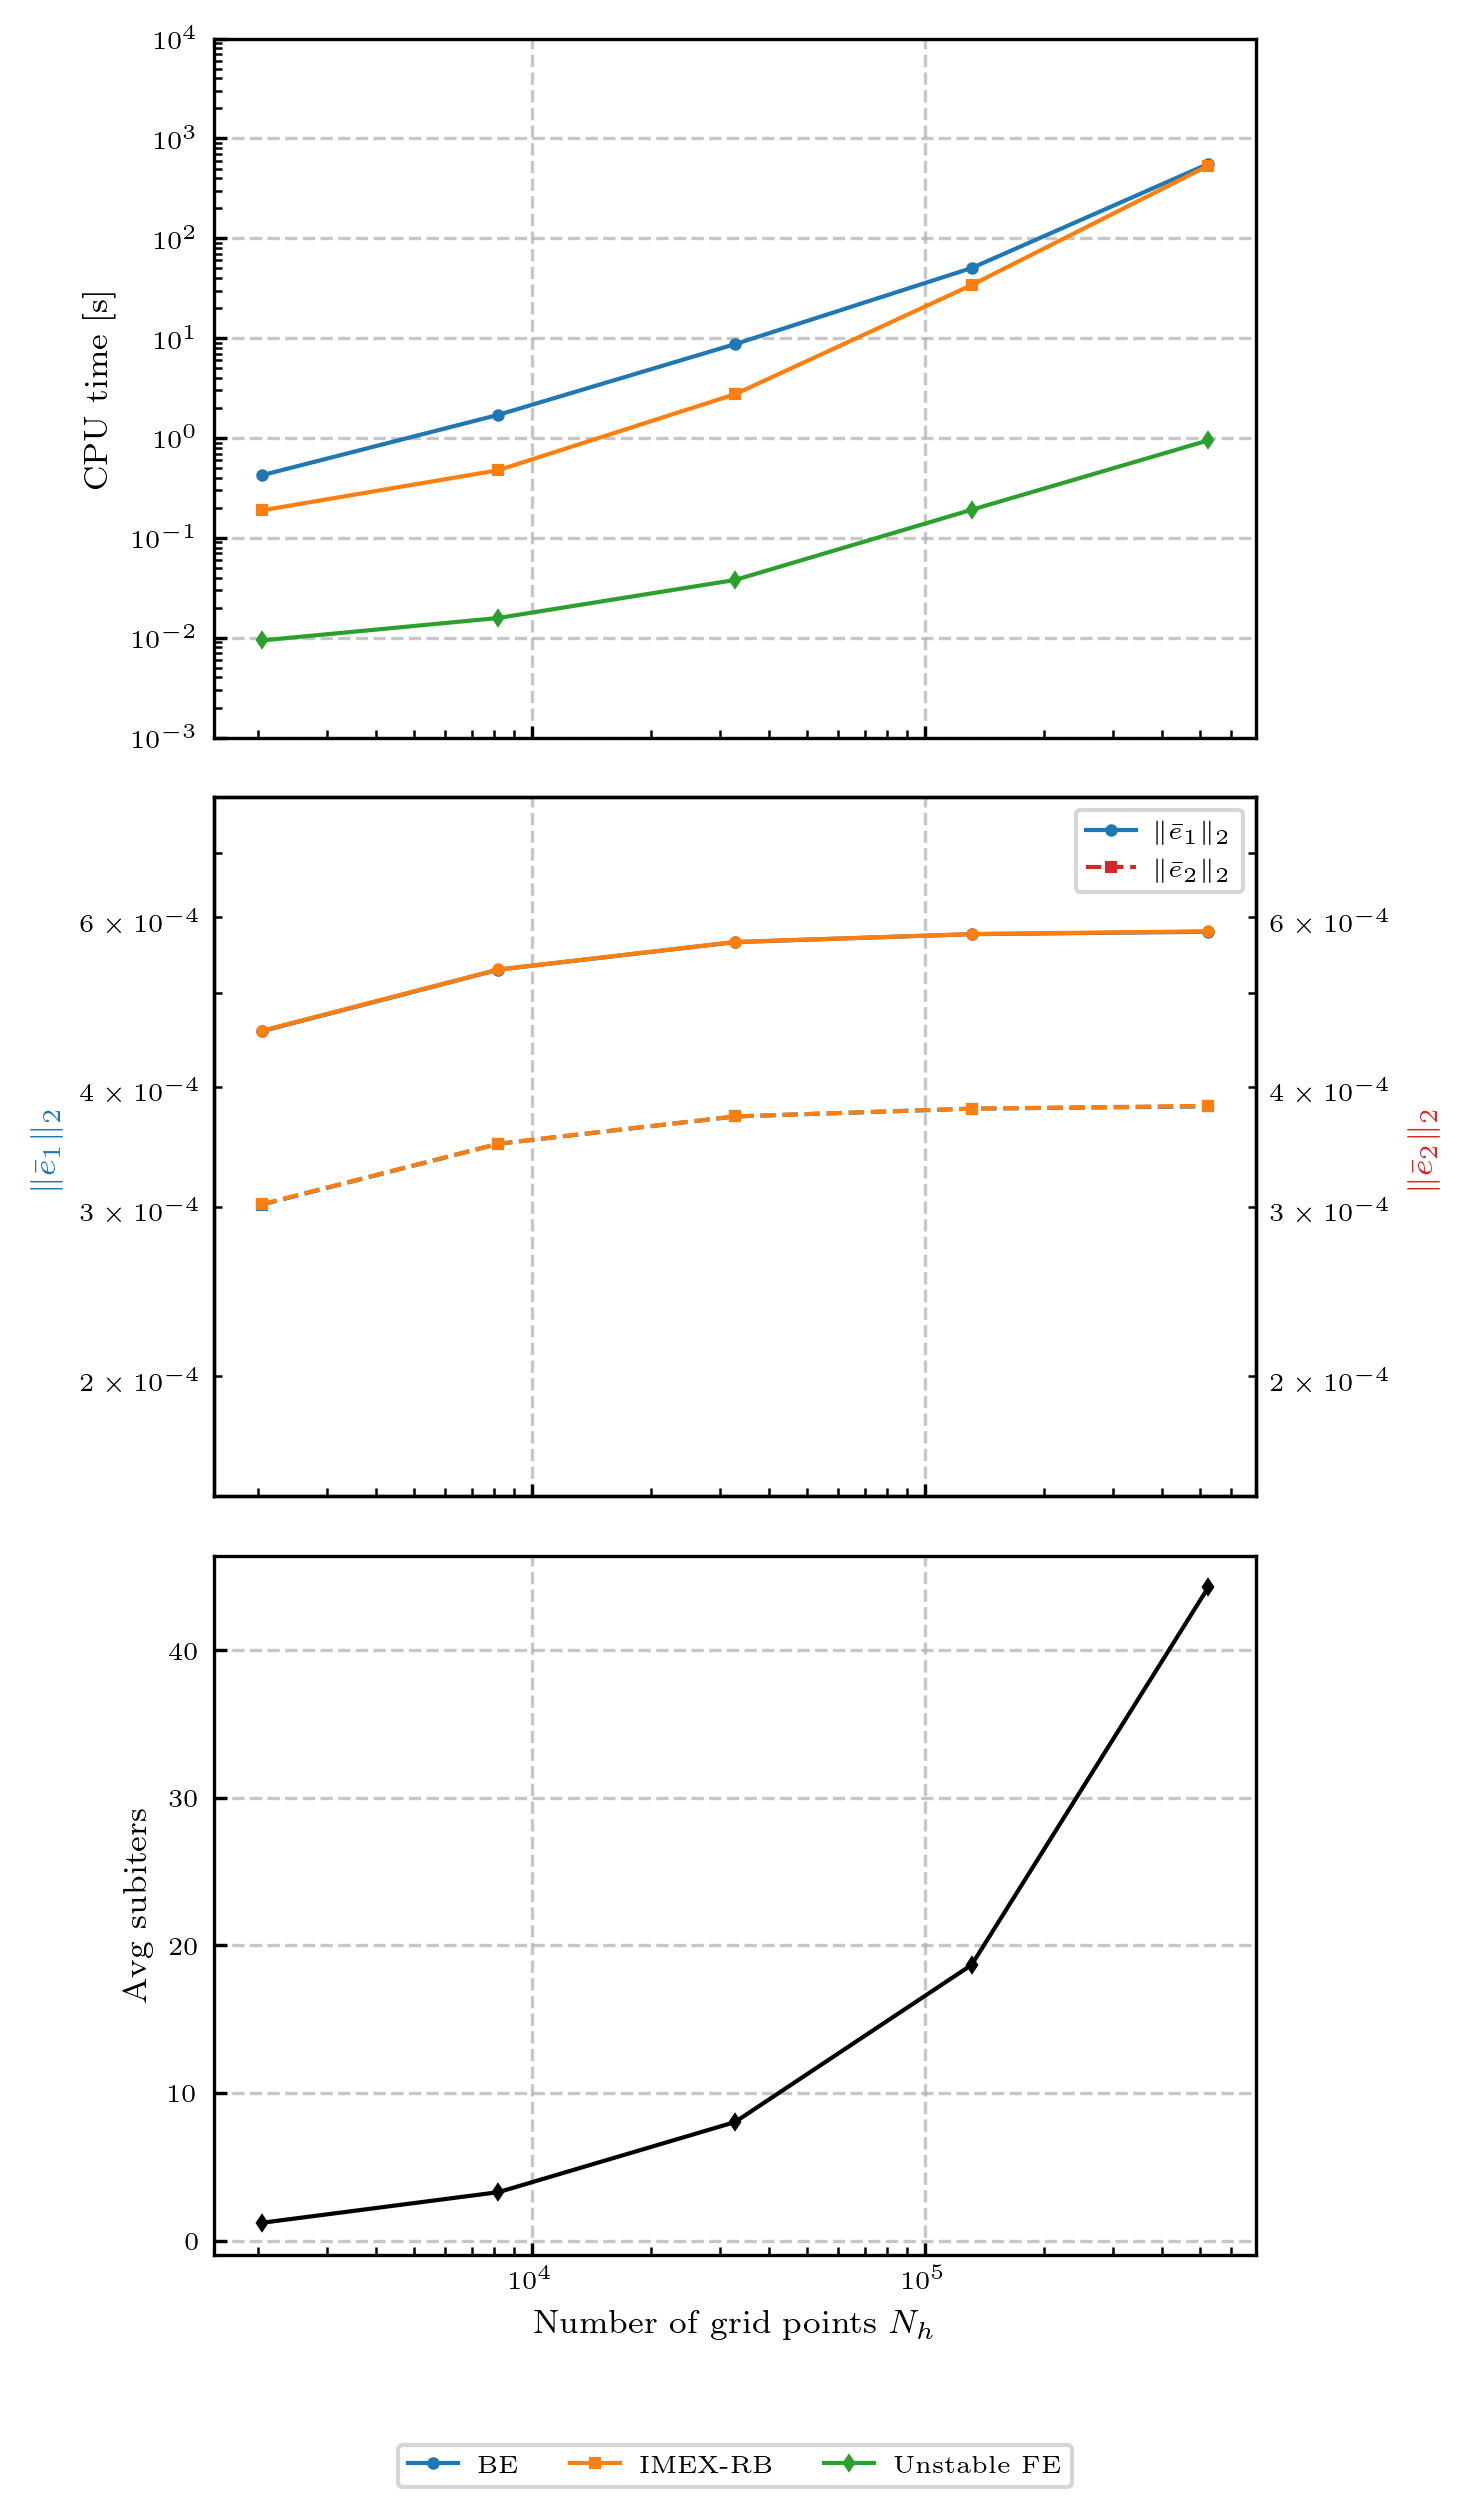

In [ ]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "CPUtimes"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, 'results', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']
subiters = data['subiters'].item()['IMEX-RB']

methods = ['BE', 'IMEX-RB', 'FE']
methods_labels = ['BE', 'IMEX-RB', 'Unstable FE']
methods_marker = ['o', 's', 'd']
comp_labels = ['u_x', 'u_y']

# Create subplot grid: 3 rows, 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 3), sharex=True)

# First row: CPU times
for ctr_m, m in enumerate(methods):
    ax1.loglog(Nh_values, times[m], marker=methods_marker[ctr_m], label=methods_labels[ctr_m])
ax1.set_ylabel('CPU time [s]')
ax1.set_ylim((1e-3, 1e4))

# Second row: L2 errors with dual y-axes
# Left y-axis for u_1 component
for m in methods[:-1]:
    ax2.loglog(Nh_values, errors_l2[m][0], marker='o', color='C0' if m == 'BE' else 'C1')
ax2.set_ylabel(fr'$\|\bar{{e}}_1\|_2$', color='tab:blue')
ax2.set_ylim((1.5e-4, 8e-4))
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis for u_2 component
ax2_right = ax2.twinx()
for m in methods[:-1]:
    ax2_right.loglog(Nh_values, errors_l2[m][1], marker='s', linestyle='--', 
                     color='C0' if m == 'BE' else 'C1')
ax2_right.set_ylabel(fr'$\|\bar{{e}}_2\|_2$', color='tab:red')
ax2_right.set_ylim((1.5e-4, 8e-4))
ax2_right.tick_params(axis='y', labelcolor='tab:red')

# Third row: Average sub-iterations
ax3.semilogx(Nh_values, np.mean(subiters, axis=1), color='k', marker='d', linestyle="-")
ax3.set_ylabel(fr'Avg subiters')
ax3.set_xlabel('Number of grid points $N_h$')

# Create custom legend entries for the dual y-axis plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='tab:blue', marker='o', label=r'$\|\bar{e}_1\|_2$'),
    Line2D([0], [0], color='tab:red', marker='s', linestyle='--', label=r'$\|\bar{e}_2\|_2$')
]
ax2.legend(handles=legend_elements, loc='upper right')

# Main legend for methods (from first plot)
fig.legend(methods_labels, bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=3)
plt.tight_layout()
out_file = os.path.join(
    plots_dir, 'Burgers2D_cputimes_errors.pdf'
)
plt.savefig(out_file, bbox_inches='tight')
plt.show()
plt.close()